# ERF and Role of Clouds

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )



In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [5]:
input_dir = '~/data/wifi-aus/statistics/'

dave = xr.open_dataset( f'{input_dir}/wifiaus-combined-vars-latrange.nc')

In [6]:
dave.load()

<xarray.Dataset>
Dimensions:         (time: 3, lon: 1, lev: 47, mode: 5, ensemble: 37,
                     latrange: 3)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-16T14:52:30 ... 2020-03-16T...
  * lon             (lon) float64 0.0
  * lev             (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0
  * mode            (mode) object 'fire0.0' 'fire1.0' ... 'fire3.0' 'fire5.0'
  * ensemble        (ensemble) object 'nudged' 'ens1.000000' ... 'ens1.000070'
  * latrange        (latrange) object '[-20, -90]' '[20, -20]' '[90, 20]'
Data variables: (12/132)
    q               (latrange, mode, ensemble, time, lev, lon) float64 2.964e...
    xl              (latrange, mode, ensemble, time, lev, lon) float64 0.0 .....
    xi              (latrange, mode, ensemble, time, lev, lon) float64 1.841e...
    sh_vdiff        (latrange, mode, ensemble, time, lon) float64 17.61 ... 2...
    ev_vdiff        (latrange, mode, ensemble, time, lon) float64 2.378e-05 ....
    ch_concloud     (latrange, mode, ensemble, time, lon) float64 35.82 ... 3...
    ...              ...
    FSW_TOTAL_SUR   (latrange, mode, ensemble, time, lon) float64 -2.038 ... ...
    FLW_CLEAR_TOP   (latrange, mode, ensemble, time, lon) float64 0.1715 ... ...
    FLW_TOTAL_TOP   (latrange, mode, ensemble, time, lon) float64 0.09981 ......
    FLW_CLEAR_SUR   (latrange, mode, ensemble, time, lon) float64 0.5477 ... ...
    FLW_TOTAL_SUR   (latrange, mode, ensemble, time, lon) float64 0.2382 ... ...
    LTS             (latrange, mode, ensemble, time, lon) float64 -14.16 ... ...

## Variable Mappings 

In [7]:
orig_names   = ['srad0', 'trad0', 'FSW_TOTAL_TOP', 'FLW_TOTAL_TOP' ]
mapped_names = ['ERF_sw', 'ERF_lw', 'IRF_sw', 'IRF_lw'] 

name_dict = {key: mapped_names[i] for i, key in enumerate(orig_names)}

forcing_allsky = dave[orig_names]
forcing_allsky = forcing_allsky.rename_vars( name_dict )

forcing_allsky = forcing_allsky.expand_dims('sky')
forcing_allsky['sky'] = ['allsky',]

In [8]:
orig_names   = ['sraf0', 'traf0', 'FSW_CLEAR_TOP', 'FLW_CLEAR_TOP' ]
mapped_names = ['ERF_sw', 'ERF_lw', 'IRF_sw', 'IRF_lw'] 

name_dict = {key: mapped_names[i] for i, key in enumerate(orig_names)}

forcing_clearsky = dave[orig_names]
forcing_clearsky = forcing_clearsky.rename_vars( name_dict )

forcing_clearsky = forcing_clearsky.expand_dims('sky')
forcing_clearsky['sky'] = ['clearsky',]

In [9]:
forcing = xr.concat( [forcing_allsky, forcing_clearsky], dim = 'sky')

### More Vars 

In [10]:
for forctype in ['ERF', 'IRF']:
    forcing[f'{forctype}_net']   = forcing[f'{forctype}_sw'] + forcing[f'{forctype}_lw']
    
for rad_component in ['sw', 'lw', 'net']:
    forcing[f'Adj_{rad_component}'] = forcing[f'ERF_{rad_component}'] - forcing[f'IRF_{rad_component}']

In [11]:
def stats_and_nudged( v ):
    
    v_stats = ens_stat( v )
    
    v_nudged = v.sel(ensemble = 'nudged')
    v_nudged = v_nudged.expand_dims('stats')
    v_nudged['stats'] = ['nudged',]
    dv_nudged = v_nudged.sel( mode = v_stats.mode ) - v_nudged.sel( mode = 'fire0.0' )
    v_stats = xr.concat( [v_stats, dv_nudged], dim = 'stats')                            
        
    
    return v_stats.squeeze()

In [12]:
forc_stats = stats_and_nudged( forcing )

In [13]:
cre = forc_stats.sel(sky = 'allsky') - forc_stats.sel( sky = 'clearsky')

## Scaled Bar Plot

In [14]:
def forcing_overview_plot(forc_stats, stats_method = 'ensemble', alpha_method = 'confidence', only_plot_modemean = False,
                          add_nudged = False, ylim = 1, title = None, ylabel = None, ax = None, legend_labelsize = 16,
                          print_condition_label = True, 
                          varnames = ['IRF_sw', 'Adj_sw', 'ERF_sw', 'IRF_lw', 'Adj_lw', 'ERF_lw', 'IRF_net', 'Adj_net', 'ERF_net',],
                          colors = ['xkcd:sun yellow', 'gold', 'orange', 'tab:red', 'darkred', 'purple', 'yellowgreen', 'forestgreen', 'darkgreen']):

    
    if 'sky' in forc_stats.coords:
        nrows = 2
        skys = forc_stats.sky
    else:
        nrows = 1
        skys = [np.array(['none']),]
    
    if ax is None:
        fig, axs = plt.subplots( nrows = nrows, figsize = (20, 3 * nrows))
        if nrows == 1:
            axs = [axs,]
    else:
        axs = [ax,]
        
    plt.subplots_adjust( hspace = 0.6, top = 0.85, right = 0.8 )
    
    if title is None:
        title = stats_method
    
    x = 0
    dmode = 0.1
    dvar = dmode * 1
    dtime = dmode * 2
    dlatrange = dmode * 4
    
    
    scale = [1., 2., 3., 5.]
    scale_factors = xr.DataArray( data = np.array(scale), dims = 'mode', 
                                      coords = dict( mode = ('mode', forc_stats.mode.data) ) )
    months = ['Jan', 'Feb', 'Mar']
    
    for isky, sky in enumerate( skys ):
        plt.sca( axs[isky] )
        if nrows > 1:
            axs[isky].set_title( str( sky.values ), fontweight = 'bold')
            fstat_sky = forc_stats.sel( sky = sky )
        else:
            axs[isky].set_title( title, fontsize = 22, fontweight = 'bold', x = 0.46, ha = 'center' )
    
            fstat_sky = forc_stats
            
        x = 0
        latlabel_points = []


        
        for ilat, latrange in enumerate(forc_stats.latrange):
            for itime, time in enumerate(forc_stats.time):
                for ivar, vname in enumerate( varnames ):
                    fmodes = fstat_sky[vname].sel( time = time, latrange = latrange) / scale_factors
                    
                    frange = fmodes.sel(stats = 'mean').std('mode') #- fmodes.sel(stats = 'mean').min('mode')
                    fmodemean = fmodes.sel(stats = 'mean').mean('mode')
                    fnu_modemean = fmodes.sel(stats = 'nudged').mean('mode')
                    
                    if ivar == 5:
                        plt.text(x, -0.7* ylim, months[itime], ha = 'center', fontsize = 14)

                    for imode, mode in enumerate( forc_stats.mode):
                        f = fmodes.sel( mode = mode,)
                        fs = f # / scale[imode]
                        fnudged = fs.sel(stats = 'nudged')
                        
                        if stats_method == 'nudged':
                            fmean = fnudged
                            fmodemean = fnu_modemean
                            alpha = 1.
                        else:
                            fmean = fs.sel(stats = 'mean')
                            if alpha_method == 'confidence':
                                fconf = fs.sel(stats = 'confidence')
                                alpha_condition = np.abs(fmean/fconf) > 1

                            elif alpha_method == 'mode_range':
                                alpha_condition = np.abs(fmodemean/frange) > 1
                            
                            elif alpha_method == 'agree_with_nudged':
                                alpha_condition = fnu_modemean * fmodemean > 0 # else they have different sign 
                                
                            if alpha_condition:
                                alpha = 1.
                            else:
                                alpha = 0.25


                        if only_plot_modemean:
                            plt.bar(x, fmodemean, color = colors[ivar], width = dmode * 0.8, alpha = alpha)
                            if not add_nudged:
                                break
                        else:
                            plt.bar(x, fmean, color = colors[ivar], width = dmode * 0.8, alpha = alpha)
                            
                        if add_nudged:
                            if only_plot_modemean:
                                plt.plot(x, fnu_modemean, color = 'gray', marker = '_')
                                break
                            else:
                                plt.plot(x, fnudged, color = 'gray', marker = '_')

                        if not only_plot_modemean:
                            x += dmode
                        
                    x += dvar
                
                x += dtime
                

                
            latlabel_points += [x,]
            x += dlatrange

        latlabel_points = np.array( latlabel_points )
        latlabel_points -= latlabel_points[0]/2
        
        plt.xticks(latlabel_points, ['Southern Hemisphere', 'Tropics', 'Northern Hemisphere'], fontsize = 18) 
        plt.ylim(-ylim, ylim)
        if ylabel is None:
            plt.ylabel('Forcing \n (W m${}^{-2}$)' )
        else:
            plt.ylabel(ylabel)
        
        y = 0.7
        for ivar, vname in enumerate( varnames ):
            offset = 0.002
            plt.figtext(0.82 + offset/5, y - offset, vname, color = 'k', fontsize = legend_labelsize)
            plt.figtext(0.82, y, vname, color = colors[ivar], fontsize = legend_labelsize)
            
            y-=0.06
            
            if np.mod(ivar + 1, 3) == 0:
                y -= 0.02
        
    if stats_method == 'ensemble' and print_condition_label:
        plt.figtext(0.8, 0.8, 'Condition: ' + alpha_method, fontsize = 'small')

## Plots for Paper

In [15]:
fallsky = forc_stats.sel( sky = 'allsky' )
del fallsky['sky']

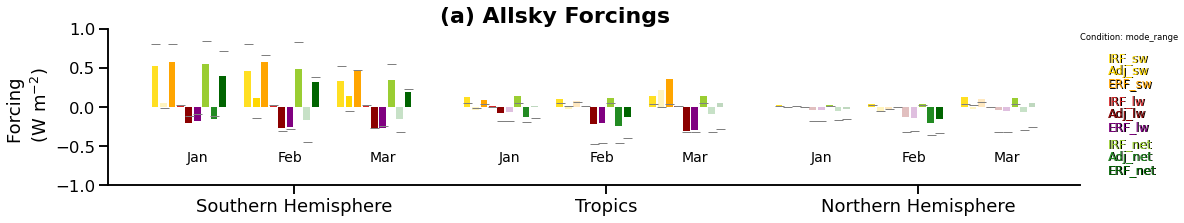

In [16]:
forcing_overview_plot(fallsky, stats_method = 'ensemble', 
                      alpha_method = 'mode_range', 
                      #ylabel = 'CRE \n (W m${}^{-2}$)',
                      title = '(a) Allsky Forcings',
                      legend_labelsize = 12,
                      only_plot_modemean=True, add_nudged = True)

plt.savefig('../pics/allsky_forcing.png', dpi = 600)

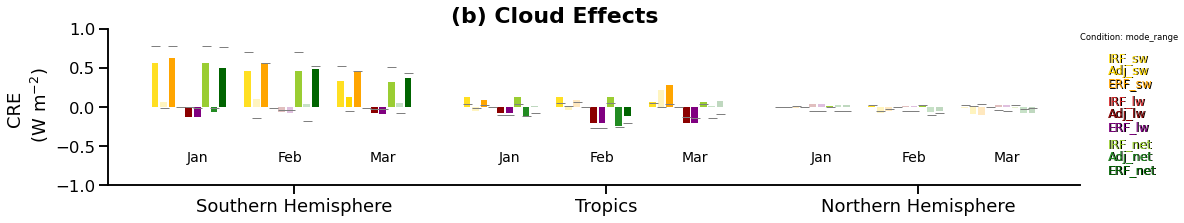

In [17]:
forcing_overview_plot(cre, stats_method = 'ensemble', 
                      alpha_method = 'mode_range', 
                      ylabel = 'CRE \n (W m${}^{-2}$)',
                      title = '(b) Cloud Effects',
                      legend_labelsize = 12,
                      only_plot_modemean=True, add_nudged = True)

plt.savefig('../pics/cloud_effects_on_forcing.png', dpi = 600)

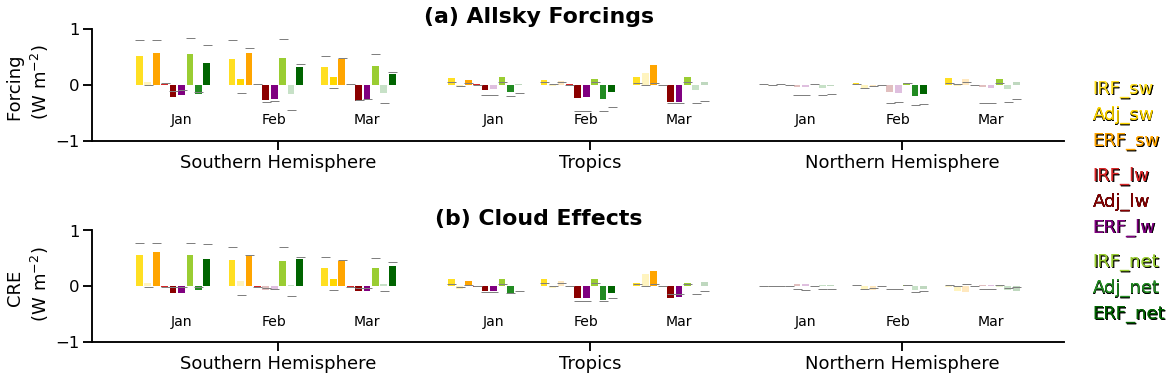

In [18]:
fig, axs = plt.subplots( nrows = 2, figsize = (20, 6))

base_kws = dict(      stats_method = 'ensemble', 
                      alpha_method = 'mode_range', 
                      #ylabel = 'CRE \n (W m${}^{-2}$)',
                      legend_labelsize = 18,
                      print_condition_label = False,
                      only_plot_modemean=True, add_nudged = True
               )

forcing_overview_plot(fallsky, 
                      ax = axs[0],
                      title = '(a) Allsky Forcings', **base_kws)

forcing_overview_plot(cre, 
                      ax = axs[1],
                      ylabel = 'CRE \n (W m${}^{-2}$)',
                      title = '(b) Cloud Effects', **base_kws )

plt.subplots_adjust( hspace = 0.8 )
plt.savefig('../pics/forcing-and-clouds.png', dpi = 600)

##  More Detailed Plot for Supplement

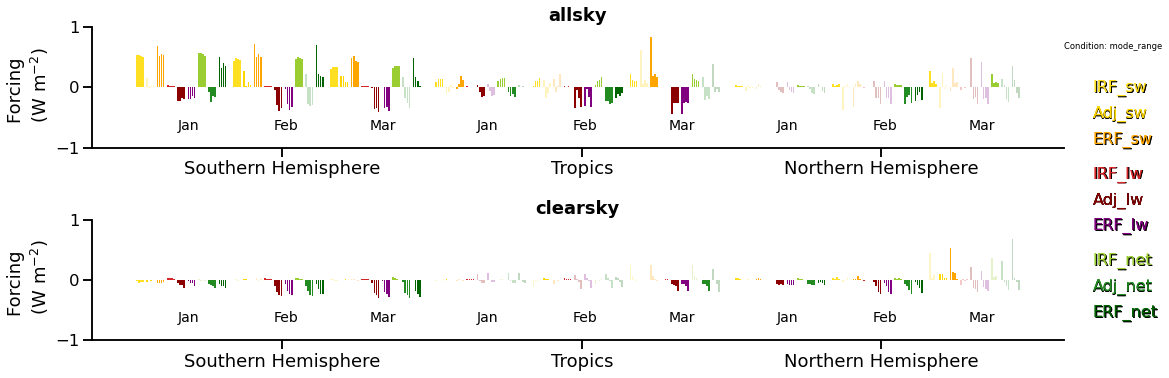

In [19]:
forcing_overview_plot(forc_stats, stats_method = 'ensemble', alpha_method = 'mode_range')

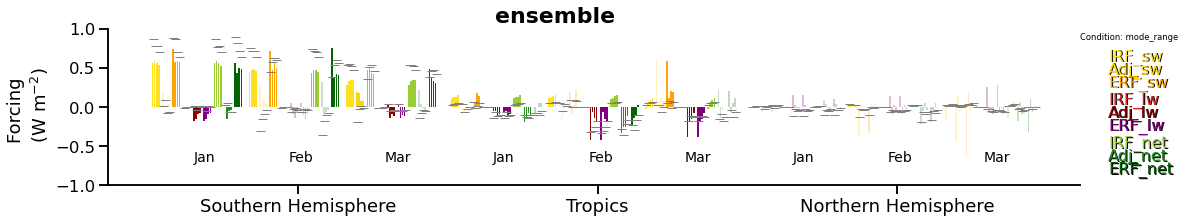

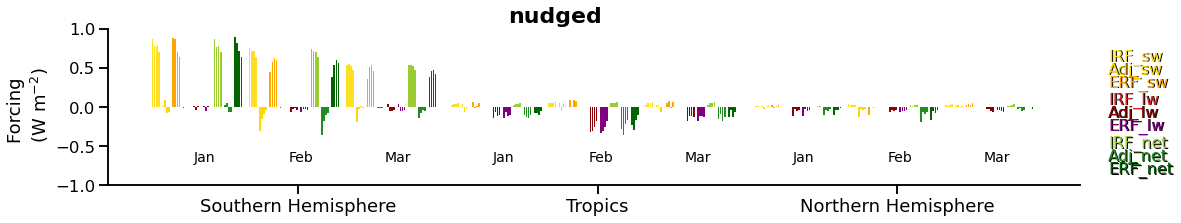

In [20]:
forcing_overview_plot(cre, stats_method = 'ensemble', alpha_method = 'mode_range', add_nudged = True)
forcing_overview_plot(cre, stats_method = 'nudged')

**Takeaways**:

* forcings:
    - SH: dominated by shortwave instantaneous forcing at the beginning, the sw IRF decreases with time and positive sw adjustments become more and more important and buffer the incline the sw ERF. Stratospheric adjustments build up a negative longwave perturbation that lasts longer than the sw forcing
    - tropics: longwave adjustments induce a negaive forcing (primarily from the stratosphere), with time, positive shortwave forcings develop which counterbalance the longwave leading to a zero net effective forcing in the tropics 
    - NH: response very uncertain, small negative longwave adjustment, perhaps due to stratospheric adjustments, appear in the clearsky signal
    
* cloud effects:
    - SH: clouds increase the positive IRF in the SH by 0.5 W/m2. Cloud also enhance the negative longwave forcing due to adjustment to some degree.
    - tropics: the presence of clouds also enhances the negative longwave forcing in the tropics. Adjustment in cloud characteristics may lead to counterbalancing shortwave effects over time, these response are highly uncertain (discrepancies between free ensemble and nudged simulations)
    - NH: There is either negligible or extremly uncertain effect of clouds in the NH, in the sw, lw as well as in the net part.